<a href="https://colab.research.google.com/github/BJUNEJA/nomadgene/blob/master/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision 
import torchvision.transforms as transforms 
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torchvision.utils import save_image

In [0]:
## set up hyperparameters
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 1e-3 
log_interval = 10
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [0]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [0]:
class VEncoder(nn.Module):
  def __init__(self):
    super(VEncoder, self).__init__()
    self.fc1 =nn.Linear(784,400);
    self.fc_mu = nn.Linear(400,20);
    self.fc_var =nn.Linear(400,20)

  def forward(self,x):
    x = F.relu(self.fc1(x))
    x= x.view(x.size(0),-1)
    x_mu = self.fc_mu(x)
    x_var = self.fc_var(x)
    return x_mu, x_var 


In [0]:
class VDecoder(nn.Module):
  def __init__(self):
    super(VDecoder,self).__init__()
    self.fc1=nn.Linear(20,400)
    self.fc2=nn.Linear(400,28*28)

  def forward(self,x):
    x=F.relu(self.fc1(x))
    x=torch.sigmoid(self.fc2(x))
    return x  

In [0]:
class VAE(nn.Module):
  def __init__(self):
    super(VAE,self).__init__()
    self.encoder = VEncoder()
    self.decoder = VDecoder()

  def forward(self,x):
    mean_vector, var_vector =self.encoder(x)
    ## sample from the distribution characterized by the  measures of location and variability estimated by encoder. 
    ## this is where reparametrization trick comes to play. z= mu + sigma.epsilon where epsilon ~Normal(0,1) 
    ## Also this is the latent vector that will be fed to decoder. 
    ##This is arguably the most tricky part of chicken neck of autoencoder to get right else nothing works
    stdev = var_vector.mul(0.5).exp_()
    epsilon = torch.empty_like(stdev).normal_()
    sampled_latent_vector = epsilon.mul(stdev).add_(mean_vector)
    reconstructed_vector = self.decoder(sampled_latent_vector)
    return mean_vector, var_vector, sampled_latent_vector, reconstructed_vector


In [0]:
modelV = VAE()
optimizer = torch.optim.Adam(modelV.parameters(), lr=learning_rate)
train_loss_list = []
train_index = []
train_loss_avg = []
test_loss_list = []
epoch_list =[]
epoch_loss=[]
test_index = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

Train Epoch: 1 [0/60000 (0%)]	Loss: 35005.679688
Train Epoch: 1 [640/60000 (1%)]	Loss: -120183.039062
Train Epoch: 1 [1280/60000 (2%)]	Loss: -457784.968750
Train Epoch: 1 [1920/60000 (3%)]	Loss: -451316.718750
Train Epoch: 1 [2560/60000 (4%)]	Loss: -426885.031250
Train Epoch: 1 [3200/60000 (5%)]	Loss: -487371.531250
Train Epoch: 1 [3840/60000 (6%)]	Loss: -476131.156250
Train Epoch: 1 [4480/60000 (7%)]	Loss: -567113.687500
Train Epoch: 1 [5120/60000 (9%)]	Loss: -585163.187500
Train Epoch: 1 [5760/60000 (10%)]	Loss: -760046.500000
Train Epoch: 1 [6400/60000 (11%)]	Loss: -812173.375000
Train Epoch: 1 [7040/60000 (12%)]	Loss: -949215.875000
Train Epoch: 1 [7680/60000 (13%)]	Loss: -913976.812500
Train Epoch: 1 [8320/60000 (14%)]	Loss: -903487.812500
Train Epoch: 1 [8960/60000 (15%)]	Loss: -1024740.187500
Train Epoch: 1 [9600/60000 (16%)]	Loss: -980190.625000
Train Epoch: 1 [10240/60000 (17%)]	Loss: -975895.937500
Train Epoch: 1 [10880/60000 (18%)]	Loss: -1109367.875000
Train Epoch: 1 [11520

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type VEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type VDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


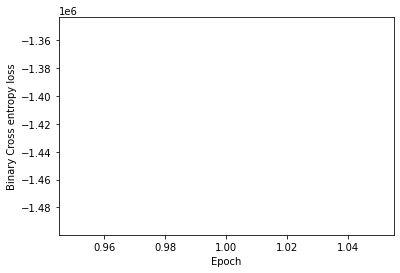

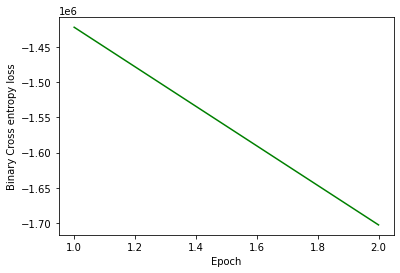

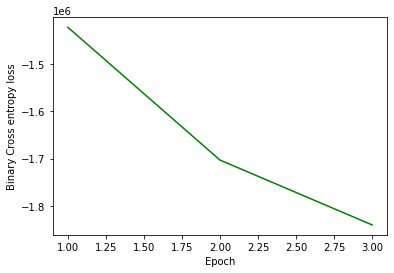

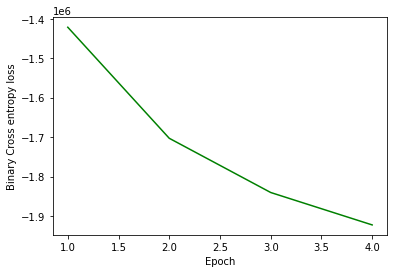

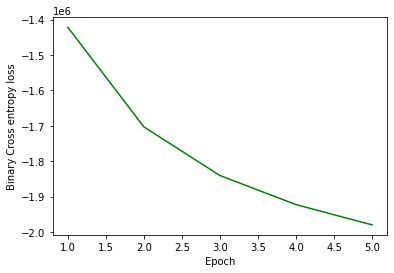

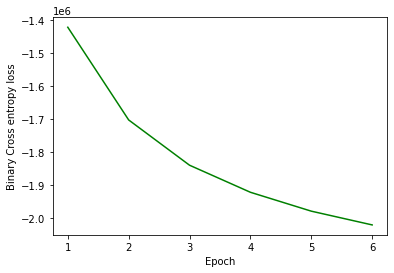

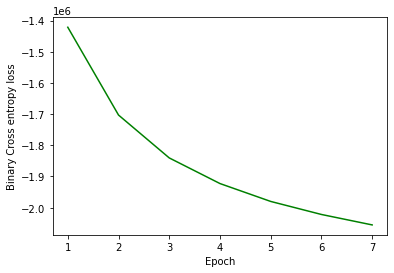

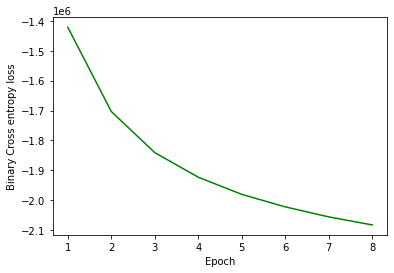

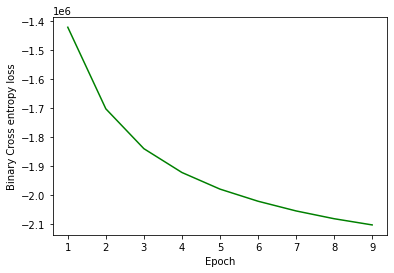

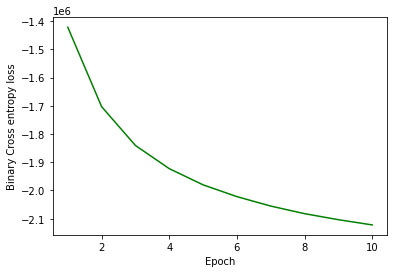

In [0]:
for epoch in range(1, n_epochs + 1):
  for idx, (image,target) in enumerate(train_loader):
    train_loss_avg.append(0)
    num_batches = 0
    image, target =Variable(image),Variable(target)
    image = image.view(image.size(0), -1)   #flatten original image 
    optimizer.zero_grad()
    latent_mean_vec,latent_var_vec,sampled_latent_vec,reconstruction_vec = modelV(image)
    reconstruction_loss = F.binary_cross_entropy(reconstruction_vec.view(-1, 784), image.view(-1, 784), reduction='sum')
    ### this is slightly different formulation from what is stated in Problem but its working  
    kldivergence = -0.5 * torch.sum(1 + latent_var_vec - latent_mean_vec.pow(2) - latent_var_vec.exp())
    loss= reconstruction_loss + 1 * kldivergence 
    loss.backward() 
    optimizer.step()
    if idx % log_interval == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, idx * len(image), len(train_loader.dataset),100. * idx / len(train_loader), loss.item()))
          train_loss_list.append(loss.item())
          train_index.append((idx*32) + ((epoch-1)*len(train_loader.dataset)))
  epoch_list.append(epoch)
  epoch_loss.append(torch.mean(torch.FloatTensor(train_loss_list)))
  fig = plt.figure()
  plt.plot(epoch_list, epoch_loss, color='green')
  plt.xlabel('Epoch')
  plt.ylabel('Binary Cross entropy loss')
  save_image(image.view(image.size(0), 1, 28, 28), 'pr7_Original_Epoch_%03d.png' % (epoch) )
  save_image(reconstruction_vec.view(reconstruction_vec.size(0), 1, 28, 28), 'pr7_Reconstruction_Epoch_%03d.png' % (epoch) )
  

torch.save(modelV, './hw5vae.pth')


In [0]:
with torch.no_grad():

  latent = torch.randn(128, 20)
  img_reconstruction = modelV.decoder(latent)
  save_image(img_reconstruction.view(img_reconstruction.size(0), 1, 28, 28), 'pr7_latent_image.png')
  